## ARIMA
- http://ucanalytics.com/blogs/time-series-decomposition-manufacturing-case-study-example-part-2/
- https://rpubs.com/zkajdan/316135

In [15]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/2330.TW.csv')
#df

In [17]:
df = df[~ df['Close'].isna()]

Populating the interactive namespace from numpy and matplotlib


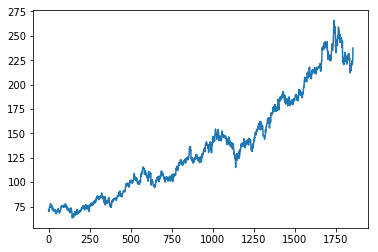

In [18]:
%pylab inline
df['Close'].plot(kind = 'line')

In [19]:
df.count()

Date         1851
Open         1851
High         1851
Low          1851
Close        1851
Adj Close    1851
Volume       1851
dtype: int64

In [20]:
trainset = df.iloc[0:1551,:]
testset  = df.iloc[1551: ,:]

In [21]:
trainset.shape

(1551, 7)

In [22]:
testset.shape

(300, 7)

In [23]:
trainset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1551,2017-04-25,190.5,192.0,189.5,192.0,179.272598,31932000.0
1552,2017-04-26,192.0,192.0,190.5,191.0,178.338898,29909000.0
1553,2017-04-27,192.0,193.0,190.5,193.0,180.206314,27940000.0
1554,2017-04-28,193.5,194.5,193.0,194.5,181.606888,34852000.0
1555,2017-05-02,198.5,199.0,195.5,196.5,183.474304,44119000.0


In [24]:
testset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1556,2017-05-03,198.0,198.5,197.0,198.0,184.874878,25723000.0
1557,2017-05-04,198.5,199.0,197.0,198.0,184.874878,22088000.0
1558,2017-05-05,197.0,198.5,197.0,197.5,184.408020,17036000.0
1559,2017-05-08,199.0,202.5,199.0,202.5,189.076569,36538000.0
1560,2017-05-09,205.5,207.0,203.5,203.5,190.010284,48077000.0


In [25]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [37]:
X = trainset.Close.values
differenced = difference(X, 365)

In [39]:
differenced

array([10.200005, 12.100006, 14.399994, ..., 53.      , 54.5     ,
       57.5     ])

In [45]:
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)

In [46]:
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)

In [47]:
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 194.959280
Day 2: 192.553089
Day 3: 192.380521
Day 4: 192.642703
Day 5: 194.489287
Day 6: 199.143919
Day 7: 197.213715


In [49]:
testset[0 : 6]

,Date,Open,High,Low,Close,Adj Close,Volume
1556,2017-05-03,198.0,198.5,197.0,198.0,184.874878,25723000.0
1557,2017-05-04,198.5,199.0,197.0,198.0,184.874878,22088000.0
1558,2017-05-05,197.0,198.5,197.0,197.5,184.408020,17036000.0
1559,2017-05-08,199.0,202.5,199.0,202.5,189.076569,36538000.0
1560,2017-05-09,205.5,207.0,203.5,203.5,190.010284,48077000.0
1561,2017-05-10,204.0,206.0,204.0,205.5,191.877701,28312000.0


In [54]:
training_set = trainset[~ trainset['Close'].isna()].iloc[:, 4:5].values

In [55]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [56]:
import numpy as np
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [63]:
import numpy as np
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [64]:
X_train.shape

(1491, 60, 1)

In [65]:
y_train.shape

(1491,)

## LSTM

In [66]:
# Importing the Keras libraries and packages
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [67]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1491/1491 [==============================] - 7s 4ms/step - loss: 0.0378
Epoch 2/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0038
Epoch 3/100
1491/1491 [==============================] - 4s 2ms/step - loss: 0.0036
Epoch 4/100
1491/1491 [==============================] - 4s 2ms/step - loss: 0.0036
Epoch 5/100
1491/1491 [==============================] - 4s 2ms/step - loss: 0.0036
Epoch 6/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0036
Epoch 7/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0034
Epoch 8/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0031
Epoch 9/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0030
Epoch 10/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0029
Epoch 11/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0031
Epoch 12/100
1491/1491 [==============================] - 4s 2ms/step - lo

1491/1491 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 98/100
1491/1491 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 99/100
1491/1491 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 100/100
1491/1491 [==============================] - 4s 2ms/step - loss: 9.9153e-04


In [71]:
real_stock_price = testset.iloc[:,4:5].values

In [72]:
dataset_total = pandas.concat((trainset['Close'], testset['Close']), axis = 0)
dataset_total.tail(30)

1827    227.0
1828    226.0
1829    229.0
1830    232.0
1831    226.5
1832    231.0
1833    225.0
1834    226.0
1835    226.5
1836    227.5
1837    218.0
1838    214.5
1839    213.0
1840    212.0
1841    216.5
1842    214.0
1843    214.5
1844    216.0
1845    214.5
1846    217.0
1847    221.5
1848    222.0
1849    220.0
1850    220.5
1851    224.5
1852    223.5
1853    221.5
1854    223.0
1855    224.5
1856    237.5
Name: Close, dtype: float64

In [74]:
inputs = dataset_total[len(dataset_total) - len(testset['Close']) - 60:].values

In [76]:
inputs = inputs.reshape(-1,1)

In [78]:
inputs = sc.transform(inputs)

In [83]:
len(inputs)

360

In [84]:
X_test = []
for i in range(60, 360):
    X_test.append(inputs[i-60:i, 0])

In [85]:
len(X_test)

300

In [87]:
X_test = np.array(X_test)

In [88]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [89]:
predicted_stock_price = regressor.predict(X_test)

In [91]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

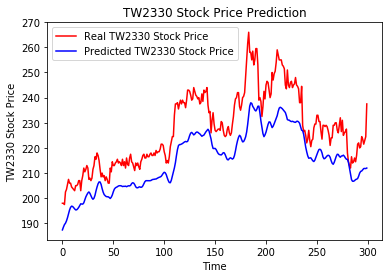

In [100]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price, color = 'red', label = 'Real TW2330 Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TW2330 Stock Price')
plt.title('TW2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TW2330 Stock Price')
plt.legend()
plt.show()

In [96]:
predicted_stock_price2 = regressor.predict(X_train)
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price2)
real_stock_price2 = training_set

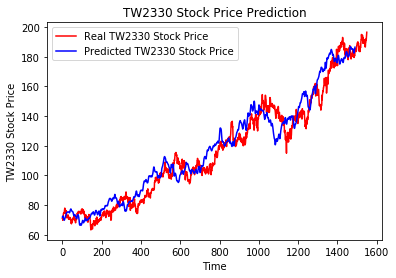

In [101]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price2, color = 'red', label = 'Real TW2330 Stock Price')
plt.plot(predicted_stock_price2, color = 'blue', label = 'Predicted TW2330 Stock Price')
plt.title('TW2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TW2330 Stock Price')
plt.legend()
plt.show()

## 預測火鍋搜尋趨勢

In [102]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/hotpot.csv', skiprows= [0,1])

In [104]:
df.columns = ['月', '火鍋']

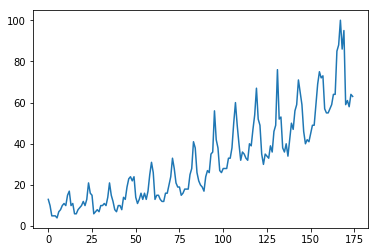

In [107]:
df['火鍋'].plot(kind='line')

In [109]:
#trainset = df['火鍋'].values

In [110]:
len(df['火鍋'].values)

175

In [112]:
dataset = df['火鍋'].values

In [113]:
X_train = []
y_train = []
for i in range(7, 175):
    X_train.append(dataset[i-7:i])
    y_train.append(dataset[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [114]:
X_train2 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [116]:
#X_train2

In [117]:
# Importing the Keras libraries and packages
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train2.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [118]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train2, y_train, epochs = 100, batch_size = 2)

Epoch 1/100
168/168 [==============================] - 2s 11ms/step - loss: 1095.9671
Epoch 2/100
168/168 [==============================] - 0s 3ms/step - loss: 786.9549
Epoch 3/100
168/168 [==============================] - 0s 3ms/step - loss: 688.7997
Epoch 4/100
168/168 [==============================] - 1s 3ms/step - loss: 607.6683
Epoch 5/100
168/168 [==============================] - 0s 3ms/step - loss: 556.2781
Epoch 6/100
168/168 [==============================] - 0s 3ms/step - loss: 491.1815
Epoch 7/100
168/168 [==============================] - 1s 3ms/step - loss: 423.6583
Epoch 8/100
168/168 [==============================] - 1s 3ms/step - loss: 374.5789
Epoch 9/100
168/168 [==============================] - 0s 3ms/step - loss: 338.1880
Epoch 10/100
168/168 [==============================] - 0s 3ms/step - loss: 303.8201
Epoch 11/100
168/168 [==============================] - 0s 3ms/step - loss: 272.9048
Epoch 12/100
168/168 [==============================] - 1s 3ms/step - lo

168/168 [==============================] - 1s 3ms/step - loss: 33.0714
Epoch 99/100
168/168 [==============================] - 0s 3ms/step - loss: 46.3079
Epoch 100/100
168/168 [==============================] - 0s 3ms/step - loss: 38.2787


In [119]:
predicted = regressor.predict(X_train2)

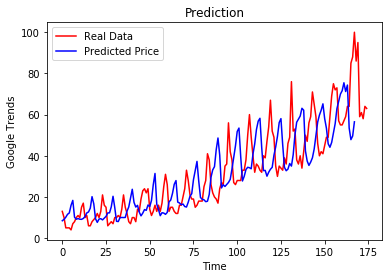

In [120]:
import matplotlib.pyplot as plt
plt.plot(dataset, color = 'red', label = 'Real Data')
plt.plot(predicted, color = 'blue', label = 'Predicted Price')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Google Trends')
plt.legend()
plt.show()

## 使用LSTM 讓電腦自動寫文章 

In [122]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path, encoding='utf-8').read().lower()
print('Corpus length:', len(text))

Corpus length: 600893


In [124]:
len(set(list(text)))

57

In [126]:
#set(list(text))

In [128]:
for i in range(0,10, 3):
    print(i)

0
3
6
9


In [129]:
# 從文章中取得序列長度
maxlen = 60

# 按步驟數進行隨機採樣
step = 3

# 保留句子的序列
sentences = []

# 保留下一個字元
next_chars = []

for i in range(0, len(text) - maxlen, step):
    # 根據step，每次取出 maxlen 的序列為 train data
    sentences.append(text[i: i + maxlen])
    # 取出序列的下一個字元當 targets
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

Number of sequences: 200278


In [131]:
# 產生詞彙表
chars = sorted(list(set(text)))
print(chars)
print('Unique characters:', len(chars))

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'æ', 'é', 'ë']
Unique characters: 57


In [134]:
# 利用字典對映 char 和索引 index
char_indices = dict((char, chars.index(char)) for char in chars)
print(char_indices)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '=': 22, '?': 23, '[': 24, ']': 25, '_': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52, 'ä': 53, 'æ': 54, 'é': 55, 'ë': 56}


In [135]:
# x：訓練樣本
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)

In [137]:
x.shape

(200278, 60, 57)

In [138]:
# y：目標樣本
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

In [139]:
y.shape

(200278, 57)

In [140]:
for i, sentence in enumerate(sentences):        # 對每個句子
    for t, char in enumerate(sentence):         # 對每個詞
        x[i, t, char_indices[char]] = 1         # 將訓練樣本做one-hot
    y[i, char_indices[next_chars[i]]] = 1       # 將標籤做one-hot

In [153]:
text[0:60]

'preface\n\n\nsupposing that truth is a woman--what then? is the'

In [151]:
text[60]

'r'

In [145]:
text[0]

'p'

In [148]:
text[60]

'r'

In [144]:
np.where(x[0][0] == True)

(array([42], dtype=int64),)

In [147]:
np.where(y[0] == True)

(array([44], dtype=int64),)

In [154]:
# 使用 LSTM 做下一個字元的預測

from keras import layers

model = keras.models.Sequential()
# 輸入為60 * 字串長度
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
# 以字元對應作為輸出
model.add(layers.Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [155]:
model.fit(x, y, batch_size=128, epochs=1)

Epoch 1/1
200278/200278 [==============================] - 150s 749us/step - loss: 2.5409


In [173]:
import random
start_index = random.randint(0, len(text) - maxlen - 1)
start_index

388318

In [174]:
generated_text = text[start_index: start_index + maxlen]
generated_text

'the frantic\nstrivings and singularities with which the freed'

In [175]:
generated_text

'the frantic\nstrivings and singularities with which the freed'

In [176]:

#temperature 低：會出現重複率比較高但是部分結構比較真實的文章。#tempera 
#temperature 高：文章會比較有意義，但可能會發明一些新詞，詞的部分結構可能不完整，有的詞只有單詞的一半
#temperature=0.5：文章生成得比較好，在結構和隨機性保持平衡的情況下，產生比較好的句子。


def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    # 根據temperature 計算
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    # 回傳多項式分布的概率
    probas = np.random.multinomial(1, preds, 1)
    # 回傳最大index
    return np.argmax(probas)

In [177]:
next_index = sample(preds, 0.5)
next_index

46

In [178]:
next_char = chars[next_index]
next_char

't'

In [179]:
generated_text += next_char

In [180]:
generated_text

'the frantic\nstrivings and singularities with which the freedt'

In [187]:
#char_indices

In [186]:
len(chars)

57

In [188]:
import random
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text = text[start_index: start_index + maxlen]

In [190]:
for i in range(400):
    sampled = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(generated_text):
        # 對字元做one-hot

        sampled[0, t, char_indices[char]] = 1

    # 計算預測的分佈值
    preds = model.predict(sampled, verbose=0)[0]
    # 輸出最大機率的字元 index
    next_index = sample(preds, 0.5)
    # 輸出字元
    next_char = chars[next_index]
    generated_text += next_char
    generated_text = generated_text[1:]

    sys.stdout.write(next_char)
    sys.stdout.flush()

 of ting ant arte the peranne wore the coresith sendes ond in the ere han the serelle the sesterithe the mert on the the gore the mont on the sore and and the indes and the indein of bereth
ond the hestore the the and the the comctore the the hore sore the soath and the hather the the couthind an the serenture somest the the pertion to sertine for the of the beringe the sheres the parely as of the

## Yelp Review
- https://github.com/Tony607/Yelp_review_generation/releases/download/V0.1/pre-trained.hdf5

In [191]:
! pip install h5py

distributed 1.21.8 requires msgpack, which is not installed.


In [192]:
import keras
from keras import layers
import sys
import numpy as np

text= 'this text file can be any text, as long as it contains text longer than maxlen defined below'

chars=['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']

# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)
maxlen=60
step=1

model = keras.models.Sequential()
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.load_weights("pre-trained.hdf5")

optimizer = keras.optimizers.Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [194]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def random_reviews():
    # sample a start index
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    # the initial sampled text with maxlen long
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with several reviews for you...')

    for temperature in [0.8]:
        sys.stdout.write(generated_text)

        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            # Turn each char to char index.
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            # Predict next char probabilities
            preds = model.predict(sampled, verbose=0)[0]
            # Add some randomness by sampling given probabilities.
            next_index = sample(preds, temperature)
            # Turn char index to char.
            next_char = chars[next_index]
            # Append char to generated text string
            generated_text += next_char
            # Pop the first char in generated text string.
            generated_text = generated_text[1:]
            # Print the new generated char.
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print(generated_text)

In [195]:
random_reviews()

Coming up with several reviews for you...
text, as long as it contains text longer than maxlen defined me with this plac

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


e. Everything on the menu is great. I had a breakfast burrito and my boyfriend was impressed with the peanut butter. I can't wait to come back and try more of their menu.<EOR>"
"<SOR>Best place to go for dosaplace with the best customer service at this place. Def recommend it to everyone.<EOR>"
"<SOR>Fantastic service! The food was excellent! The owners are super friendly and attentive too.<EOR>"
"<SOR>My hubby and I frequent this place once a month. They have a special touch with 20 eggs and hash browns. It's a bonus.  We will definitely come back again<EOR>"
"<SOR>I can't rs.  We will definitely come back again<EOR>"
"<SOR>I can't r
